# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import analysis as an
warnings.filterwarnings('ignore')

In [2]:
listNames = ['Khulan','Adrian','Mathilde','Virgil','FannyM','Margaux','JL','Hélène','Luca','Brice','ThiMai','Ani','Romain','StephB']
_type=['Grasshopper', 'Hybrid', 'Plugin']
niv=['No experience','Novice','Limited','Basic','Advanced','Expert']

In [3]:
survey=pd.read_excel("Survey.xlsx")
survey['Nom']=listNames
intro= survey.iloc[:, [4, 7, 10, 16]]
subject_level_df= survey.iloc[:, [4, 21, 24, 27, 30, 33, 36, 39, 42]]
detail= survey.iloc[:, [4, 45, 48]]
interaction1_feedback= survey.iloc[:, [4, 51, 54, 57, 60, 63]]
interaction1_feedback.set_index('Nom', inplace=True)
interaction2_feedback= survey.iloc[:, [4, 69, 72, 75, 78, 81]]
interaction2_feedback.set_index('Nom', inplace=True)
interaction3_feedback= survey.iloc[:, [4, 87, 90, 93, 96, 99]]
interaction3_feedback.set_index('Nom', inplace=True)
posteriori_interaction1_feedback= survey.iloc[:, [4, 105, 108, 111, 114, 117]]
posteriori_interaction1_feedback.set_index('Nom', inplace=True)
posteriori_interaction2_feedback= survey.iloc[:, [4, 123, 126, 129, 132, 135]]
posteriori_interaction2_feedback.set_index('Nom', inplace=True)
posteriori_interaction3_feedback= survey.iloc[:, [4, 141, 144, 147, 150, 153]]
posteriori_interaction3_feedback.set_index('Nom', inplace=True)
col=interaction1_feedback.columns
interaction2_feedback.columns=col
interaction3_feedback.columns=col
posteriori_interaction1_feedback.columns=col
posteriori_interaction2_feedback.columns=col
posteriori_interaction3_feedback.columns=col
interaction_feedback=[interaction1_feedback, interaction2_feedback, interaction3_feedback]
posteriori_interaction_feedback=[posteriori_interaction1_feedback, posteriori_interaction2_feedback, posteriori_interaction3_feedback]

subject_level_df.set_index('Nom', inplace=True)
subject_level_df=subject_level_df.applymap(an.convert_subject_level)
subject_level_df['Tot']=subject_level_df[['Rhino', 'Grasshopper']].mean(axis=1).round(0).convert_dtypes(convert_integer=True)
subject_level_df['Tot'].quantile(q=0.5)
def profile(n):
    low=n.quantile(q=0.33)
    high=n.quantile(q=0.66)
    p=[]
    for x in n:
        if x <= low:
            p.append(0)
        elif low<x<=high:
            p.append(1)
        elif high<x:
            p.append(2)
    return p

profile=subject_level_df.apply(profile, axis=0)

In [4]:
iterations_df=pd.DataFrame()
time_iterations_df=pd.DataFrame()
time_phases_df=pd.DataFrame()
time_unique_df=pd.DataFrame()
phase_df=pd.DataFrame()
unique_df=pd.DataFrame()
feedback_df=pd.DataFrame()
for name in listNames:
    path = 'input/'+ name + '/' + name +'.csv'
    test = pd.read_csv(path,sep=';')
    test["Time"] = pd.to_datetime(test["Time"],format = '%H:%M:%S:%f')
    Implementations,Index,Order = an.context_reorder(test, 0)
    diff_df_list=[]
    phase=pd.DataFrame()
    int_feedback=[_x for _, _x in sorted(zip(Order, interaction_feedback))]
    int_feedback_post=[_x for _, _x in sorted(zip(Order, posteriori_interaction_feedback))]
    unique=pd.DataFrame()
    _time_iterations=pd.DataFrame()
    _time_phases=pd.DataFrame()
    _time_unique=pd.DataFrame()
    iteration=pd.DataFrame()
    _time=[]
    i=0
    time_intervals=11
    for implementation in Implementations:
        implementation['Object']=implementation['Object'].map(lambda x:((x % 1)*10).__round__(0)).convert_dtypes(convert_integer=True)
        implementation = implementation.set_index(['Object'],append=True)
        implementation = implementation.rename_axis(['int','Object'])
        imp2=an.sub_selection(implementation,2)
        last2=imp2['Time'].iloc[-1]
        first2=imp2['Time'].iloc[0]
        imp3=an.sub_selection(implementation,3)
        last3=imp3['Time'].iloc[-1]
        first3=imp3['Time'].iloc[0]
        imp4=an.sub_selection(implementation,4)
        last4=imp4['Time'].iloc[-1]
        first4=imp4['Time'].iloc[0]
        delta_time2 = last2 - first2
        delta_time3 = last3 - first3
        delta_time4 = last4 - first4
        _time.append(delta_time2.seconds)
        _time.append(delta_time3.seconds)
        _time.append(delta_time4.seconds)
        diff_df_list.append(an.diff_analysis(an.sub_selection(implementation,2)).rename_axis([Index[i],'Object']))
        diff_df_list.append(an.diff_analysis(an.sub_selection(implementation,3)).rename_axis([Index[i],'Object']))
        diff_df_list.append(an.diff_analysis(an.sub_selection(implementation,4)).rename_axis([Index[i],'Object']))
        for k in range(2,5):
            time_unique=pd.DataFrame()
            imp=an.sub_selection(implementation,k)
            start_time=imp['Time'].iloc[0]
            imp['Time']= imp['Time'] - start_time
            imp['Time']=imp['Time'].map(lambda x:x.seconds)
            start_time=imp['Time'].iloc[0]
            end_time=imp['Time'].iloc[-1]
            timerange=end_time / time_intervals
            timerange_minutes=timerange/60
            timerange=timerange.__round__(2)
            for j in range(1, time_intervals+1):
                _imp2=imp[(imp['Time'] > start_time) & (imp['Time'] < (start_time + timerange * j))]
                _imp2=_imp2.nunique()
                imp1=imp[(imp['Time'] > start_time) & (imp['Time'] < (start_time + timerange * (j + 1)))].nunique()
                if _imp2.sum()>0:imp1=imp1-_imp2
                else:imp1=imp1*0
                time_unique=time_unique.append(imp1.drop(['Time']),ignore_index=True)

            time_unique[Index[i]]=time_unique.sum(axis=1)#.map(lambda _x:int(_x))
            if timerange>0.1:
                time_unique=time_unique[Index[i]]/timerange_minutes
            else:
                time_unique=time_unique[Index[i]]*0
            time_unique.rename(k,inplace=True)
            time_unique['Object']=k
            _time_unique=_time_unique.append(time_unique)

        _unique=pd.Series(imp2.nunique(axis=0),name=Index[i])
        _unique['Object']=2
        _unique['Order']=Order.index(i+1)+1
        unique=unique.append(_unique)
        _unique=pd.Series(imp3.nunique(axis=0),name=Index[i])
        _unique['Object']=3
        _unique['Order']=Order.index(i+1)+1
        unique=unique.append(_unique)
        _unique=pd.Series(imp4.nunique(axis=0),name=Index[i])
        _unique['Object']=4
        _unique['Order']=Order.index(i+1)+1
        unique=unique.append(_unique)
        i+=1
    i=0
    
    for diff_df in diff_df_list:
        _type_=diff_df.index.names[0]
        diff_df['Time']-=diff_df['Time'].iloc[0]
        start_time=diff_df['Time'].iloc[0]
        end_time=diff_df['Time'].iloc[-1]
        timerange= (end_time - start_time) / time_intervals
        diff_df.reset_index('Object',inplace=True)
        diff_df.set_index('Time',inplace=True)
        timeit=[]
        timerange_minutes=timerange.microseconds/60000000+timerange.seconds/60
        obj=diff_df['Object'][0]
        if timerange > (start_time-start_time):
            st=diff_df.resample(timerange, closed='left').sum()
            st[_type_]=st.drop('Object',axis=1).sum(axis=1)
            st=st.reset_index()
            st=st[_type_]
            st.iloc[-2]=st.iloc[-2]+st.iloc[-1]
            st=st.iloc[:-1]/timerange_minutes
            st['Object']=obj
        else:
            st=pd.DataFrame(data=None,index=range(11))
            st[_type_]=1
            st=st[_type_]
            st['Object']=obj
        _time_iterations=_time_iterations.append(st)

        l=((diff_df * 1).diff(1, 0) == 1)
        if timerange > (start_time-start_time):
            st=l.resample(timerange,closed='left').sum()
            st[_type_]=st.drop('Object',axis=1).sum(axis=1)
            st=st.reset_index()
            st=st[_type_]
            st.iloc[-2]=st.iloc[-2]+st.iloc[-1]
            st=st.iloc[:-1]/timerange_minutes
            st['Object']=obj
        else:
            st=pd.DataFrame(data=None,index=range(11))
            st[_type_]=1
            st=st[_type_]
            st['Object']=obj
        _time_phases=_time_phases.append(st)
        l=l.sum()
        l['Time']=_time[i]
        l['Object']=obj
        l['Order']=Order.index(_type.index(_type_)+1)+1
        l.name=_type_
        phase=phase.append(l)
        obj=diff_df['Object'][0]
        t=diff_df.sum()
        t["Total Iterations"]=t.drop(['Object']).sum()
        t['Time']=_time[i]
        t["Iterations / Minute"]=t["Total Iterations"]/(t['Time']/60)
        t['Object']=obj
        t.name=_type_
        t['Order']=Order.index(_type.index(_type_)+1)+1
        i=i+1
        iteration=iteration.append(t)

    prf=""
    for level in subject_level_df.loc[name].values:
        prf=prf+str(int(level)).strip()
    Index1=_time_iterations.index
    iterations = pd.DataFrame(iteration,index=Index1)
    iterations=iterations.set_index(['Object','Order'],append=True)
    total_iterations = pd.Series(iterations.sum(),name='Tot')
    average_iterations = pd.Series(iterations.mean(),name='Average')
    std_iterations = pd.Series(iterations.std(),name='Standard Deviation')
    iteration=iteration.append(total_iterations)
    iteration=iteration.append(average_iterations)
    iteration=iteration.append(std_iterations)
    iteration['Name']=name
    iteration['Level']=prf
    iteration['Object']=iteration['Object'].convert_dtypes(convert_integer=True)
    iteration['Order']=iteration['Order'].convert_dtypes(convert_integer=True)
    iteration.rename_axis('Type',inplace=True)
    iteration = iteration.fillna(0)
    iteration.set_index(['Name','Object','Order','Level'],append=True,inplace=True)
    iteration = iteration.reorder_levels(['Name','Level','Order','Type','Object'])
    phases = pd.DataFrame(phase,index=Index1)
    phases=phases.set_index(['Object','Order'],append=True)
    total_phases = pd.Series(phases.sum(),name='Tot')
    avg_phases = pd.Series(phases.mean(),name='Average')
    std_phases = pd.Series(phases.std(),name='Standard Deviation')
    phase=phase.append(total_phases)
    phase=phase.append(avg_phases)
    phase=phase.append(std_phases)
    phase['Name']=name
    phase['Level']=prf
    phase['Object']=phase['Object'].convert_dtypes(convert_integer=True)
    phase['Order']=phase['Order'].convert_dtypes(convert_integer=True)
    phase.rename_axis('Type',inplace=True)
    phase = phase.fillna(0)
    phase.set_index(['Name','Object','Order','Level'],append=True,inplace=True)
    phase = phase.reorder_levels(['Name','Level','Order','Type','Object'])
    unique_vals = pd.DataFrame(unique, index=Index1)
    unique_vals=unique_vals.set_index(['Object','Order'],append=True)
    tot_unique_vals = pd.Series(unique_vals.sum(),name='Tot')
    avg_unique_vals = pd.Series(unique_vals.mean(),name='Average')
    std_unique_vals = pd.Series(unique_vals.std(),name='Standard Deviation')
    unique = unique.append(tot_unique_vals)
    unique = unique.append(avg_unique_vals)
    unique = unique.append(std_unique_vals)
    unique['Name']=name
    unique['Level']=prf
    unique['Object']=unique['Object'].convert_dtypes(convert_integer=True)
    unique['Order']=unique['Order'].convert_dtypes(convert_integer=True)
    unique.rename_axis('Type',inplace=True)
    unique = unique.fillna(0)
    unique.set_index(['Name','Object','Order','Level'],append=True,inplace=True)
    unique = unique.reorder_levels(['Name','Level','Order','Type','Object'])
    Name = [name]
    Index=iteration.drop(['Tot','Average','Standard Deviation'],axis=0,level='Type').index
    Index2=Index.droplevel('Object').drop_duplicates()
    feedback_post=pd.DataFrame([int_feedback_post[0].xs(name), int_feedback_post[1].xs(name), int_feedback_post[2].xs(name)], index=Index2)
    feedback=pd.DataFrame([int_feedback[0].xs(name), int_feedback[1].xs(name), int_feedback[2].xs(name)], index=Index2)
    _time_iterations=pd.DataFrame(_time_iterations.drop(['Object'],axis=1).values, index=Index)
    _time_phases=pd.DataFrame(_time_phases.drop(['Object'],axis=1).values, index=Index)
    _time_unique=pd.DataFrame(_time_unique.drop(['Object'],axis=1).values, index=Index)

    feedback['Survey']= 'A'
    feedback_post['Survey']= 'B'
    feedback=feedback.append(feedback_post)
    feedback.set_index('Survey', append=True, inplace=True)
    unique['Max']=unique.drop('Time',axis=1).max(axis=1)
    unique['Total']=unique.drop(['Max','Time'],axis=1).sum(axis=1)
    unique['CV']=unique.drop(['Total','Max','Time'],axis=1).std(axis=1)/unique.drop(['Time','Total','Max'],axis=1).mean(axis=1)
    phase['Max']=phase.drop('Time',axis=1).max(axis=1)
    phase['Total']=phase.drop(['Max','Time'],axis=1).sum(axis=1)
    phase['CV']=phase.drop(['Total','Max','Time'],axis=1).std(axis=1)/phase.drop(['Time','Total','Max'],axis=1).mean(axis=1)

    if iterations_df.shape[0]>1:
        iterations_df = iterations_df.append(iteration)
        phase_df = phase_df.append(phase)
        unique_df = unique_df.append(unique)
        feedback_df = feedback_df.append(feedback)
        time_iterations_df=time_iterations_df.append(_time_iterations)
        time_phases_df=time_phases_df.append(_time_phases)
        time_unique_df=time_unique_df.append(_time_unique)
    elif iterations_df.shape[0]<1 :
        iterations_df=iteration
        phase_df=phase
        unique_df = unique
        feedback_df = feedback
        time_iterations_df = _time_iterations
        time_phases_df = _time_phases
        time_unique_df= _time_unique
feedback_df.columns=['Accessibility', 'Comprehension', 'Ease of Use', 'Usability', 'Satisfaction']
feedback_df=feedback_df.reset_index(['Type', 'Level', 'Order', 'Survey'], drop=False)
feedback_df=feedback_df.melt(id_vars=['Type', 'Level', 'Order', 'Survey'])

# Iterations

In [5]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', 12,'display.max_colwidth',50):
    #display(iterations_df.drop(0,level='Order').round(decimals=2))
iterations_df.round(decimals=2).to_excel('output/Iterations.xlsx')

## Étude Générale

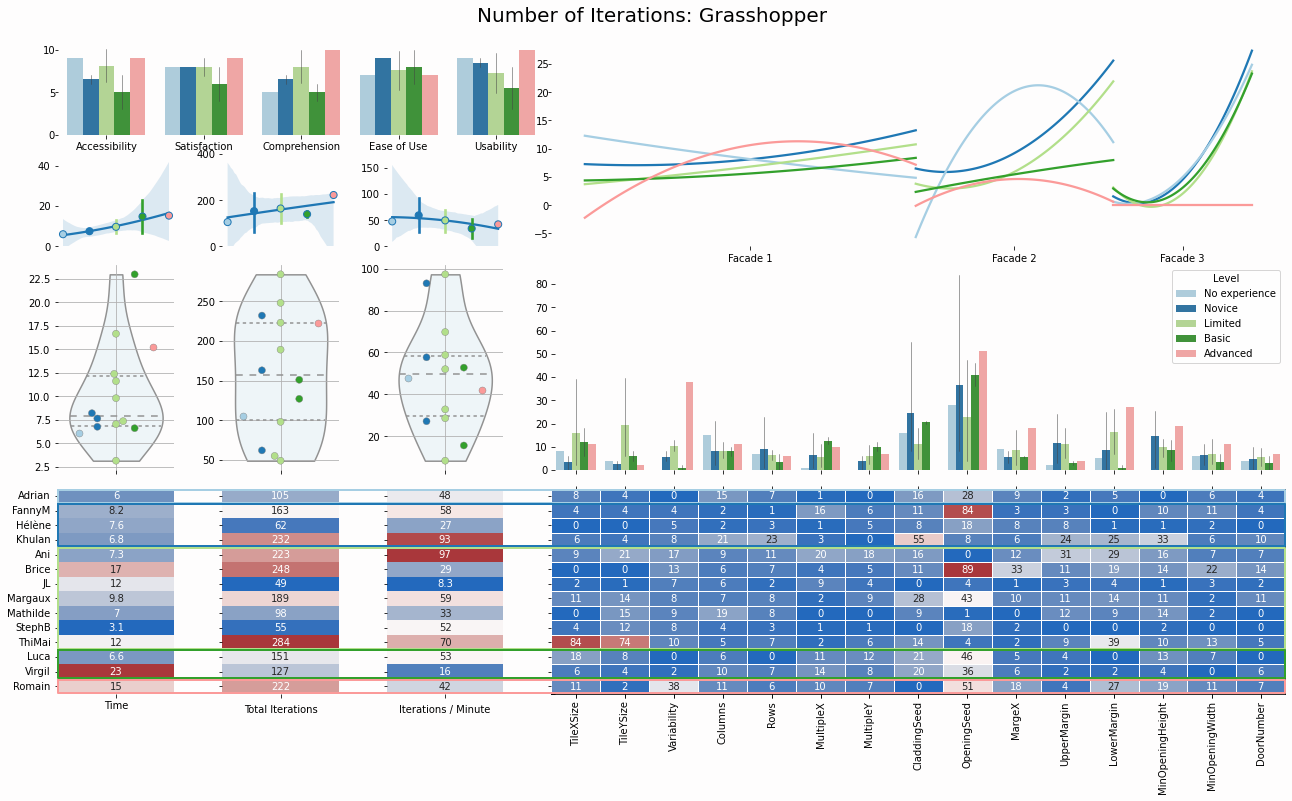

In [6]:
an.context_analysis(0, iterations_df, time_iterations_df, feedback_df, study_columns=['Time', 'Total Iterations', 'Iterations / Minute'], b=4, title='Number of Iterations')
plt.savefig('output/gh_iterations.png',bbox_inches='tight')

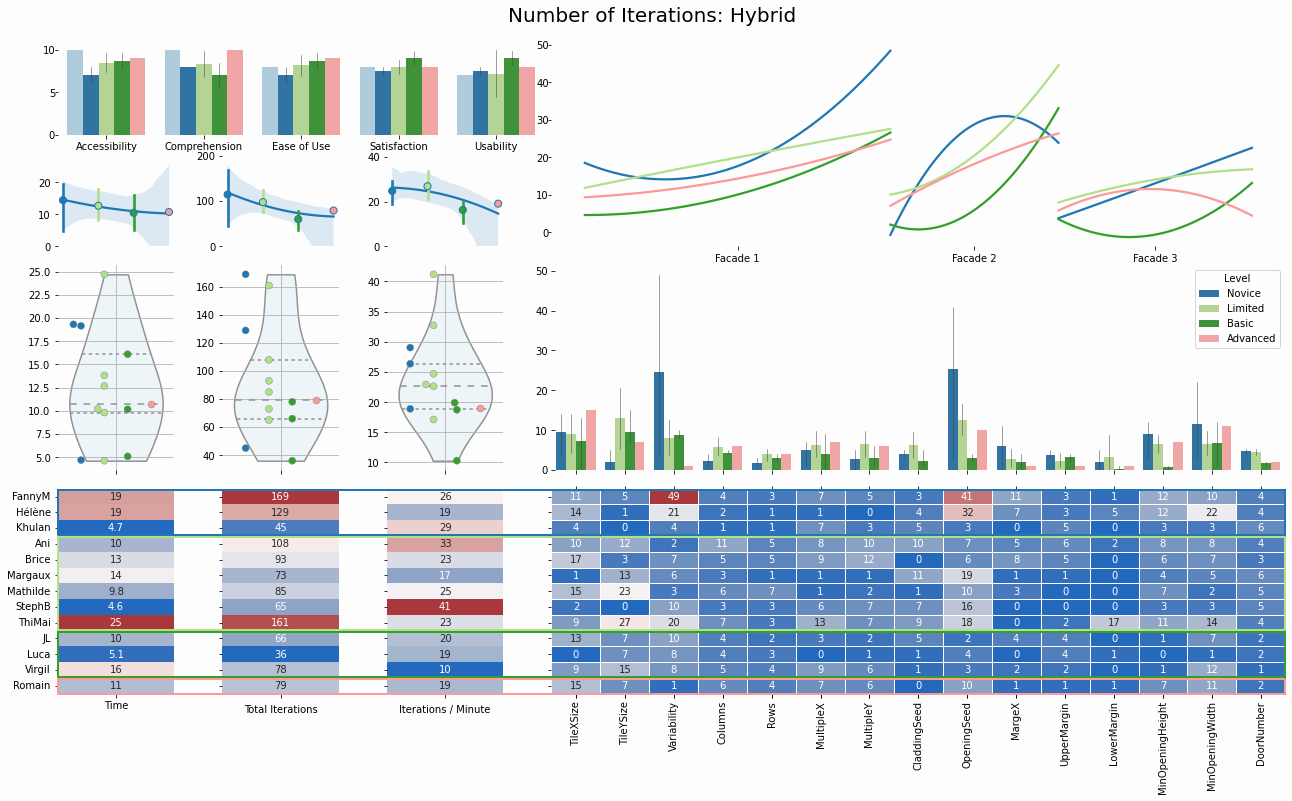

In [7]:
an.context_analysis(1, iterations_df.drop('Adrian', axis=0, level='Name'), time_iterations_df.drop('Adrian', axis=0, level='Name'), feedback_df, study_columns=['Time', 'Total Iterations', 'Iterations / Minute'], b=8, title='Number of Iterations', y2=0.1785)
plt.savefig('output/hybrid_iterations.png',bbox_inches='tight')

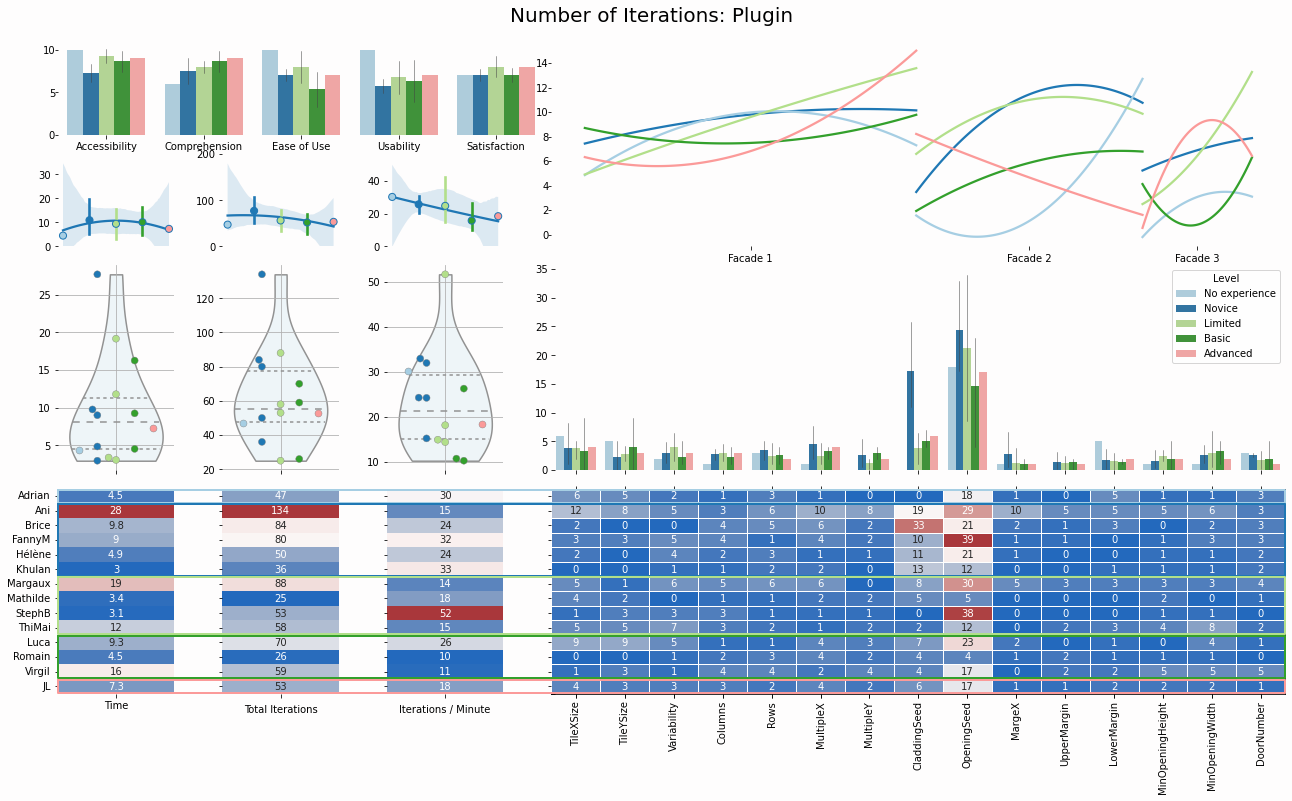

In [8]:
an.context_analysis(2, iterations_df, time_iterations_df, feedback_df, study_columns=['Time', 'Total Iterations', 'Iterations / Minute'], b=3, title='Number of Iterations')
plt.savefig('output/plugin_iterations.png',bbox_inches='tight')

### Total

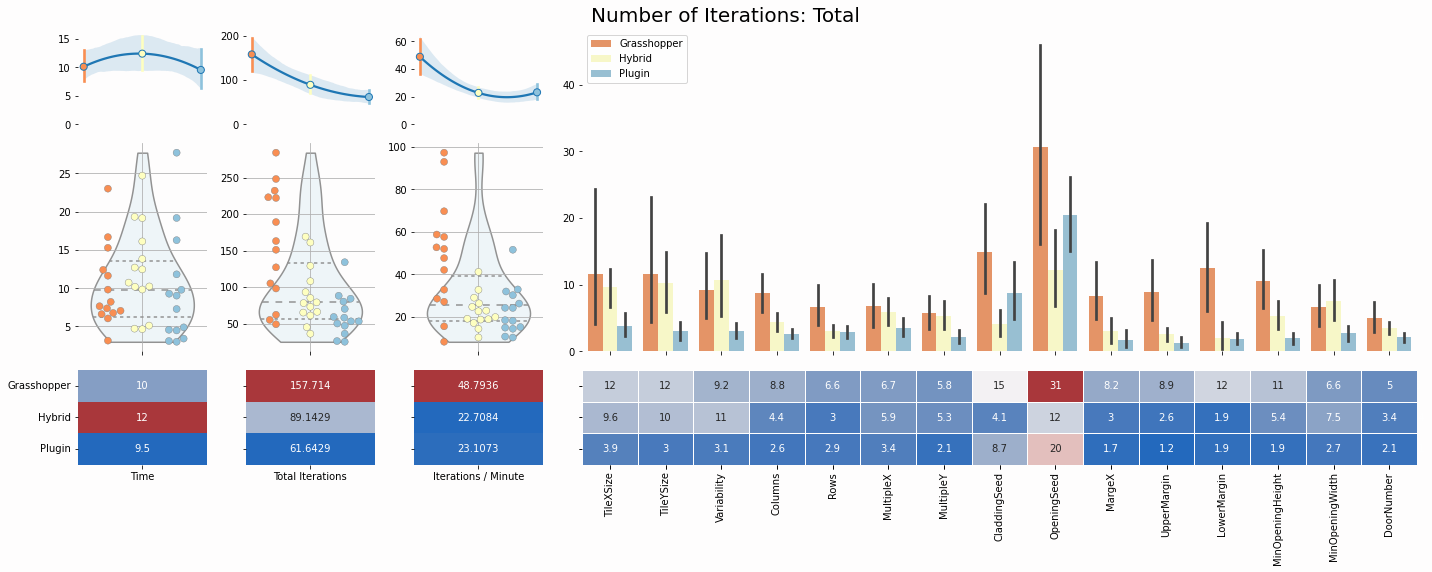

In [9]:
studycolumn=['Time','Total Iterations','Iterations / Minute']
an.global_analysis(iterations_df, studycolumn, 'Number of Iterations')
plt.savefig('output/global_iterations.png',bbox_inches='tight')

## Etude selon l'ordre

### Grasshopper

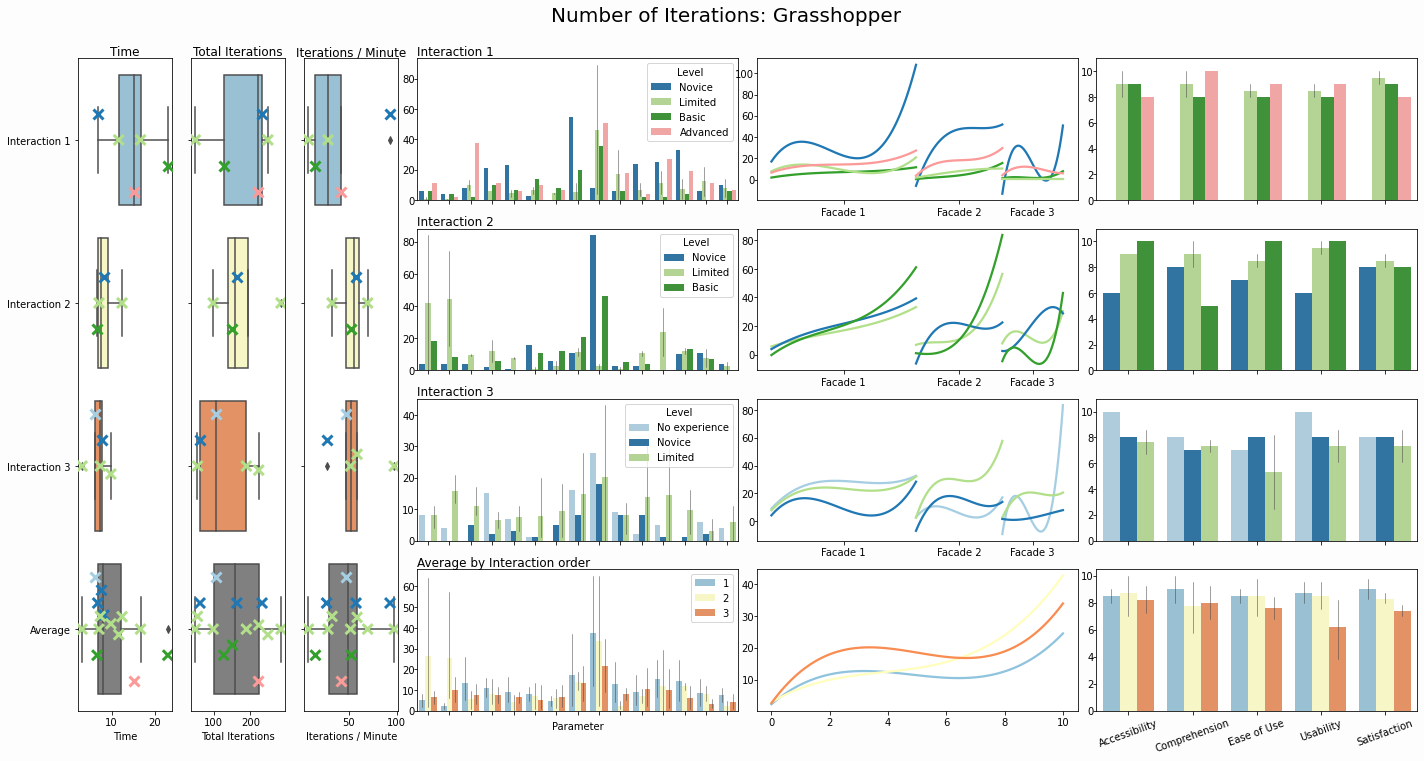

In [10]:
keeplist1 =['Time','Total Iterations','Iterations / Minute']
an.order_analysis(1, iterations_df, time_iterations_df, feedback_df, keeplist1, 4, 'Number of Iterations')
plt.savefig('output/gh_order_iterations.png',bbox_inches='tight')

### Hybrid

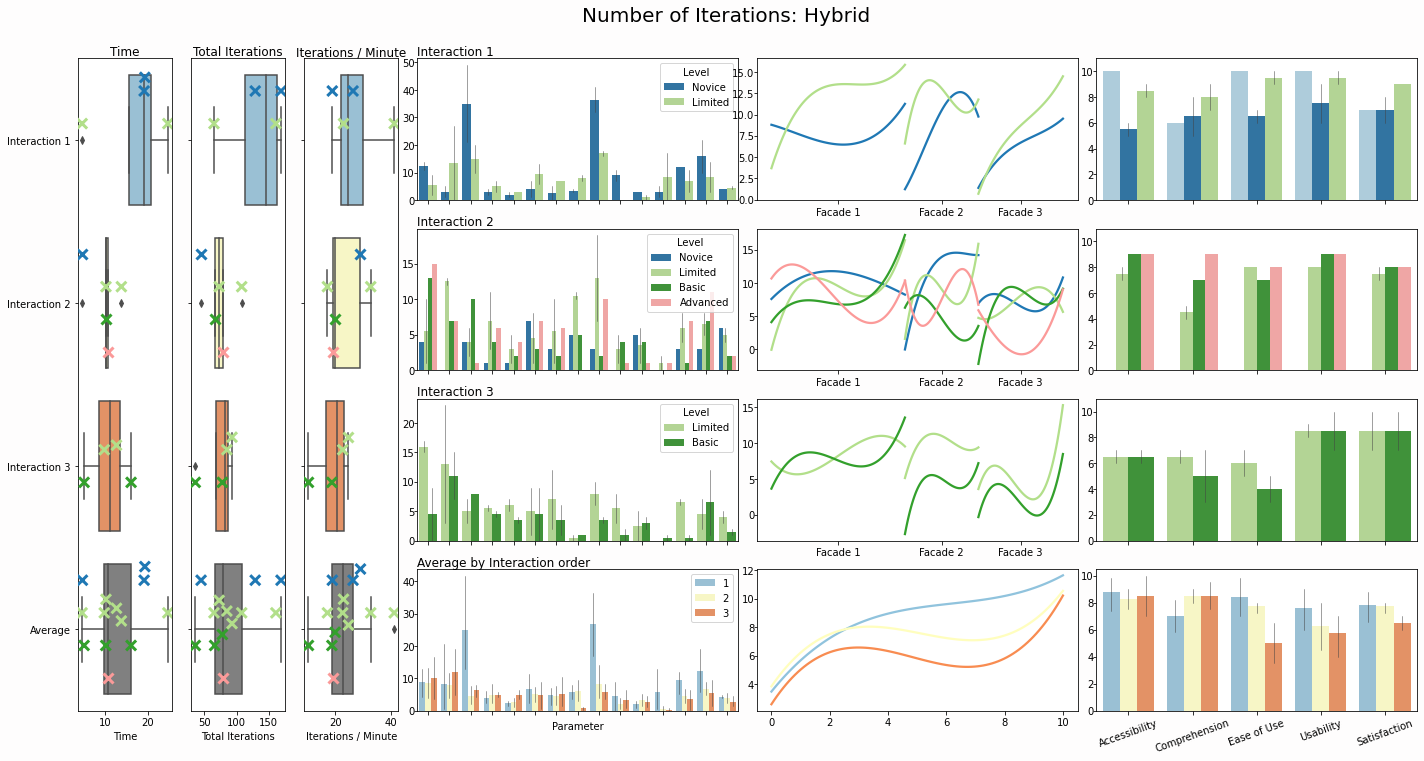

In [11]:
an.order_analysis(2, iterations_df.drop('Adrian', axis=0, level='Name'), time_iterations_df.drop('Adrian', axis=0, level='Name'), feedback_df, keeplist1, 8, 'Number of Iterations')
plt.savefig('output/hybrid_order_iterations.png',bbox_inches='tight')

### Plugin

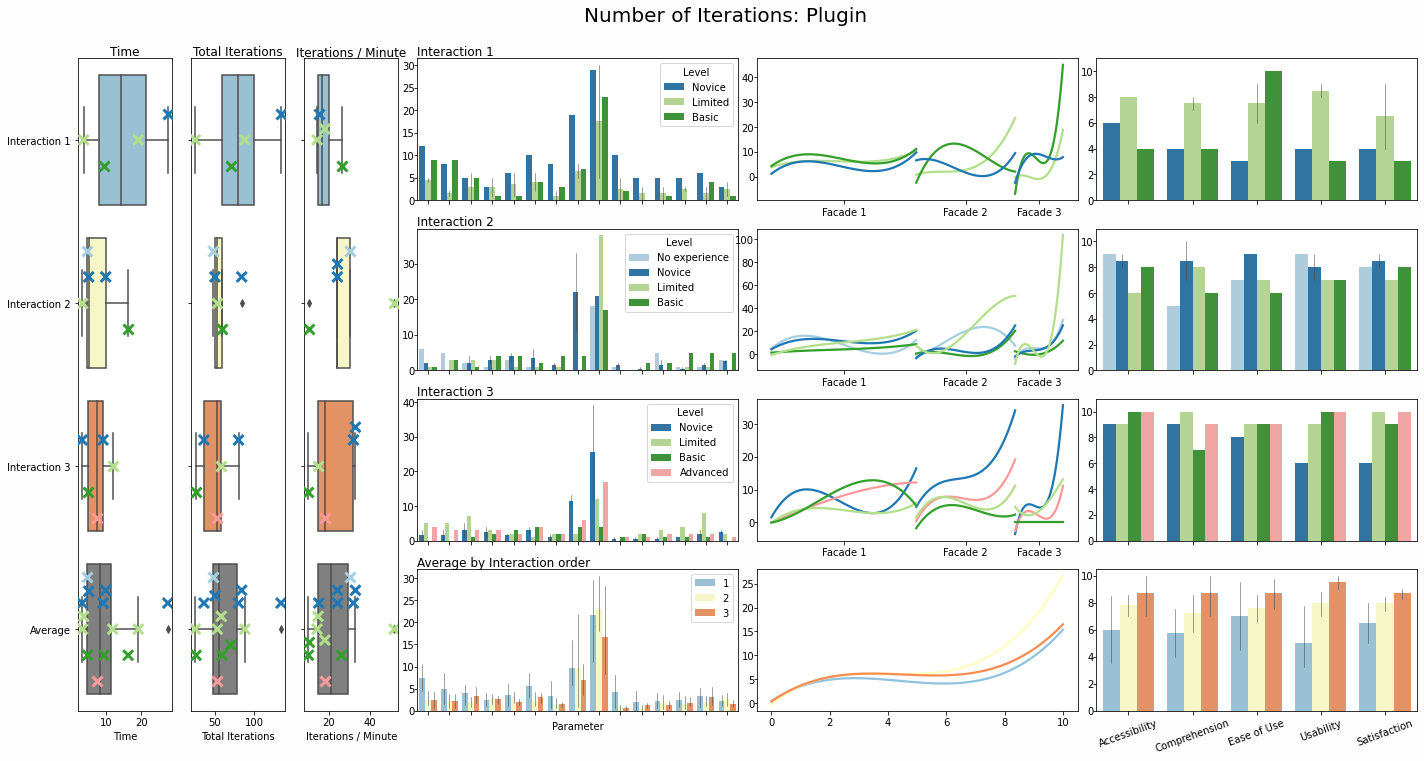

In [12]:
an.order_analysis(3, iterations_df, time_iterations_df, feedback_df, keeplist1, 3, 'Number of Iterations')
plt.savefig('output/plugin_order_iterations.png',bbox_inches='tight')

# Phases

In [13]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 12,'display.max_colwidth',50):
    display(phase_df.round(decimals=2))
iterations_df.round(decimals=2).to_excel('output/testexcel.xlsx')

TileXSize  TileYSize  \
Name     Level     Order Type               Object                         
Khulan   303112001 1     Grasshopper        2            1.00       1.00   
                                            3            1.00       0.00   
                                            4            0.00       0.00   
                   2     Hybrid             2            0.00       0.00   
                                            3            1.00       0.00   
                                            4            1.00       0.00   
                   3     Plugin             2            0.00       0.00   
                                            3            0.00       0.00   
                                            4            0.00       0.00   
                   0     Tot                0            4.00       1.00   
                         Average            0            0.44       0.11   
                         Standard Deviation 0            0.53       0.33   
Adrian   404000100 3     Grasshopper        2            1.00       1.00   
                                            3            0.00       2.00   
                                            4            1.00       0.00   
                   1     Hybrid             2            1.00       1.00   
                                            3            1.00       1.00   
                                            4            2.00       1.00   
                   2     Plugin             2            1.00       1.00   
                                            3            1.00       2.00   
                                            4            1.00       1.00   
                   0     Tot                0            9.00      10.00   
                         Average            0            1.00       1.11   
                         Standard Deviation 0            0.50       0.60   
Mathilde 404223002 2     Grasshopper        2            0.00       1.00   
                                            3            0.00       0.00   
                                            4            0.00       0.00   
                   3     Hybrid             2            0.00       0.00   
                                            3            1.00       3.00   
                                            4            1.00       1.00   
                   1     Plugin             2            1.00       1.00   
                                            3            1.00       0.00   
                                            4            1.00       0.00   
                   0     Tot                0            5.00       6.00   
                         Average            0            0.56       0.67   
                         Standard Deviation 0            0.53       1.00   
Virgil   303334003 1     Grasshopper        2            2.00       1.00   
                                            3            1.00       1.00   
                                            4            0.00       0.00   
                   3     Hybrid             2            2.00       2.00   
                                            3            0.00       0.00   
                                            4            0.00       0.00   
                   2     Plugin             2            1.00       1.00   
                                            3            0.00       1.00   
                                            4            0.00       0.00   
                   0     Tot                0            6.00       6.00   
                         Average            0            0.67       0.67   
                         Standard Deviation 0            0.87       0.71   
FannyM   404113101 2     Grasshopper        2            1.00       1.00   
                                            3            0.00       0.00   
                                            4            0.00       0.00   
                   1    

## Étude Générale

### Grasshopper

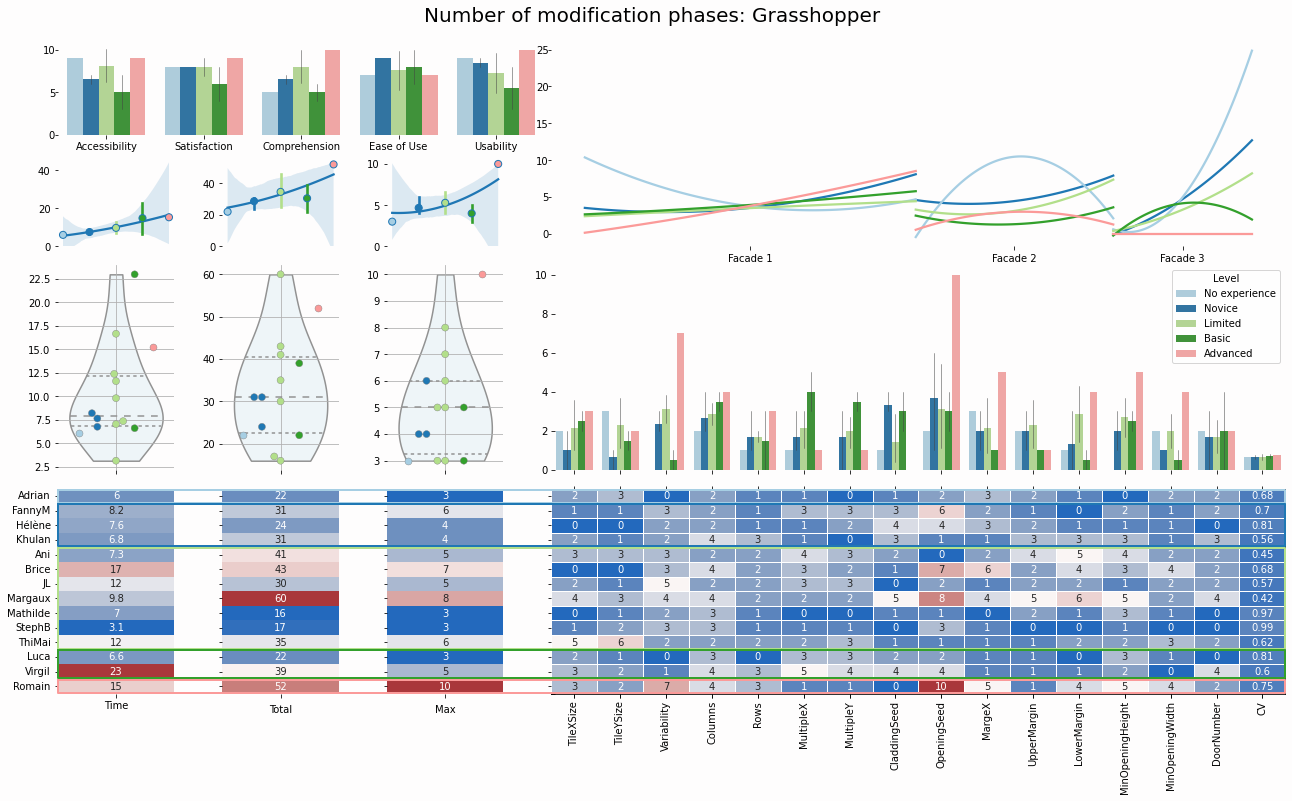

In [14]:
an.context_analysis(0, phase_df, time_phases_df, feedback_df, study_columns=['Time', 'Total', 'Max'], b=4, title='Number of modification phases')
plt.savefig('output/gh_phases.png',bbox_inches='tight')

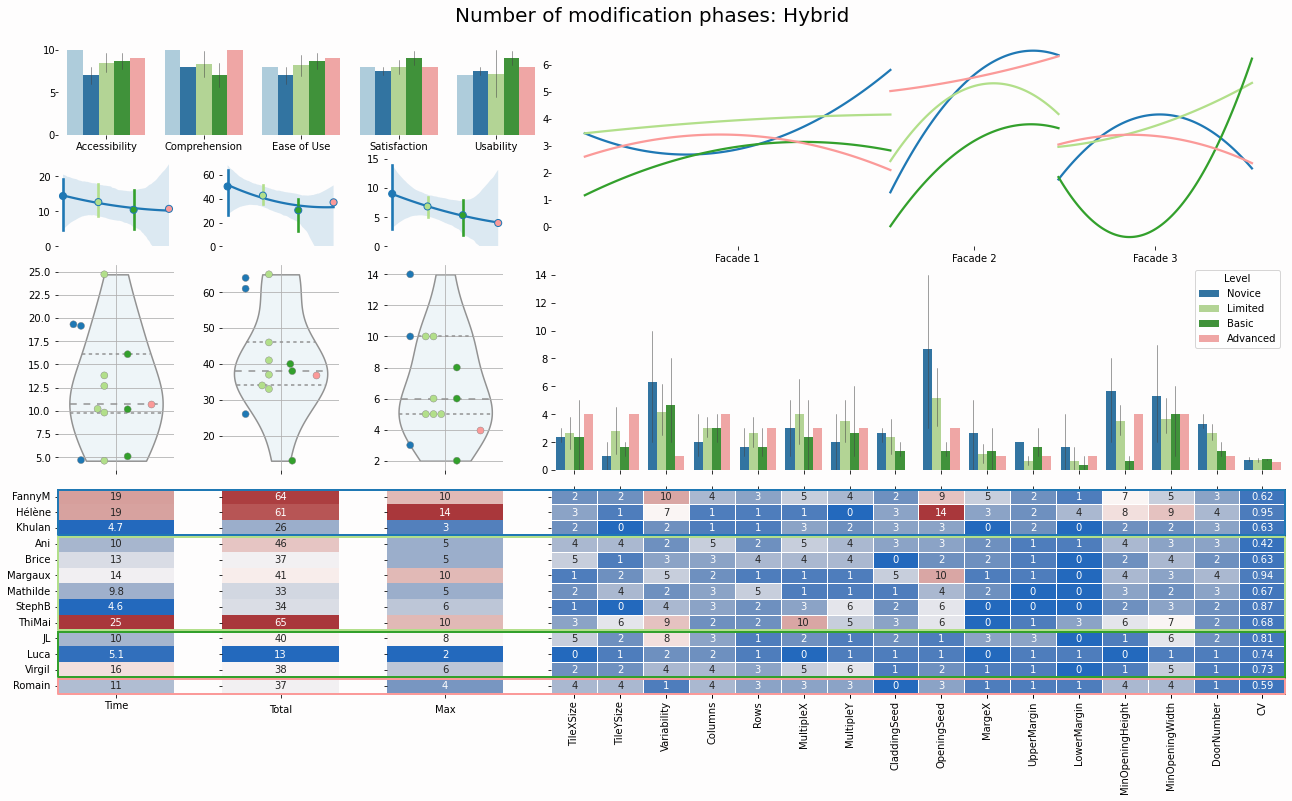

In [15]:
an.context_analysis(1, phase_df.drop('Adrian', axis=0, level='Name'), time_phases_df.drop('Adrian', axis=0, level='Name'), feedback_df, study_columns=['Time', 'Total', 'Max'], b=8, title='Number of modification phases', y2=0.1785)
plt.savefig('output/hybrid_phases.png',bbox_inches='tight')

### Plugin

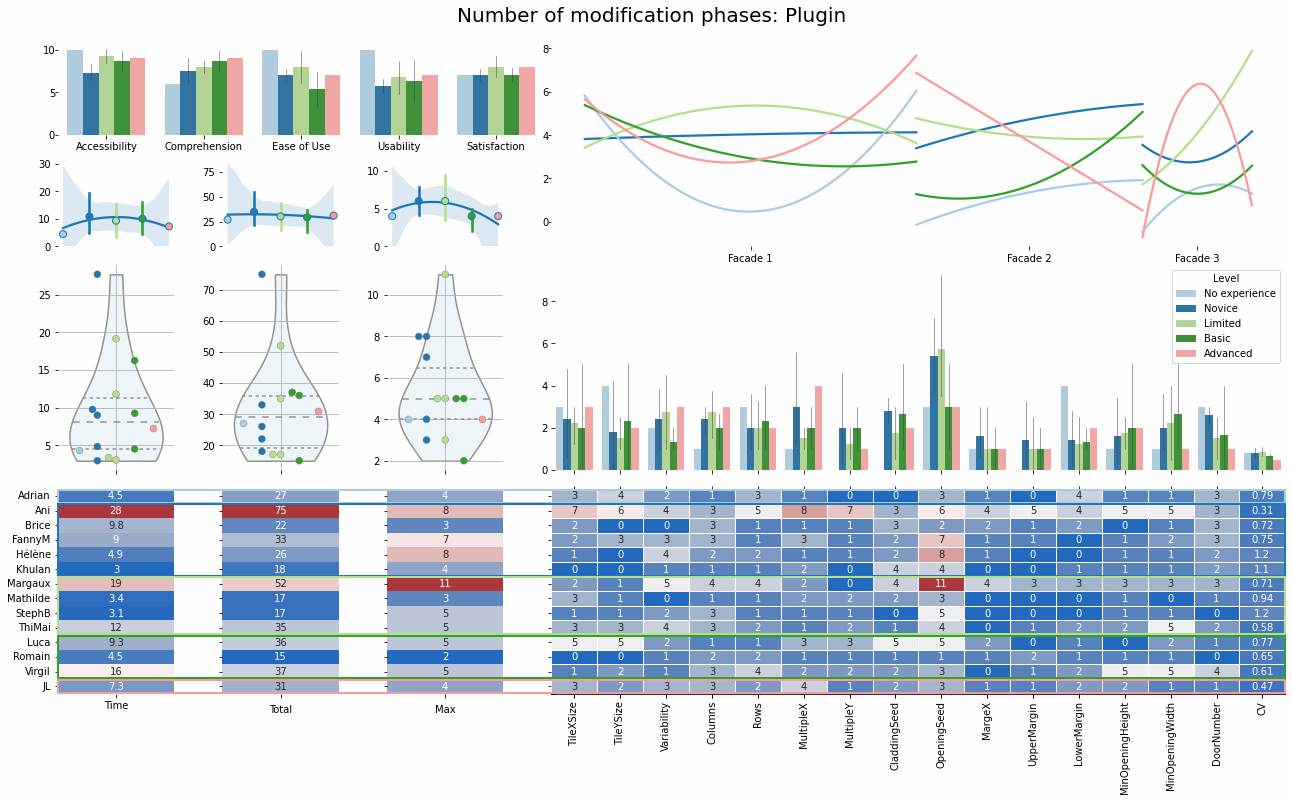

In [16]:
an.context_analysis(2, phase_df, time_phases_df, feedback_df, study_columns=['Time', 'Total', 'Max'], b=3, title='Number of modification phases')
plt.savefig('output/plugin_phases.png',bbox_inches='tight')

### Total 

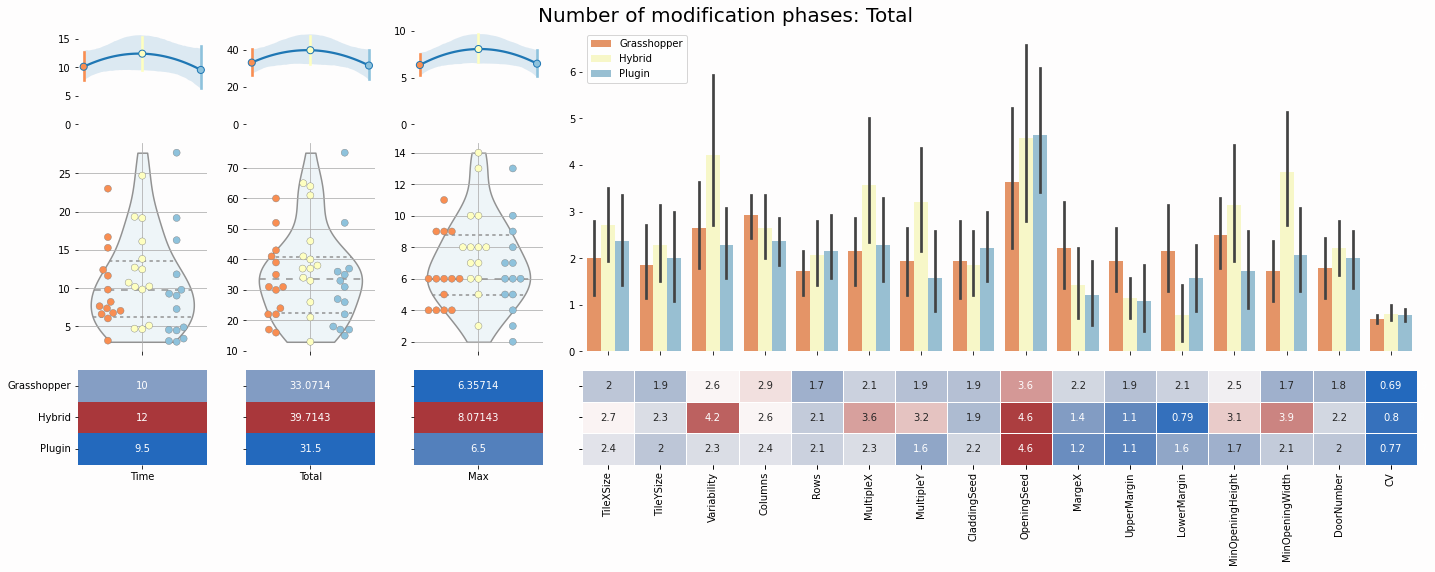

In [17]:
an.global_analysis(phase_df, ['Time', 'Total', 'Max'], 'Number of modification phases')
plt.savefig('output/global_phases.png',bbox_inches='tight')

## Etude selon l'ordre

### Grasshopper

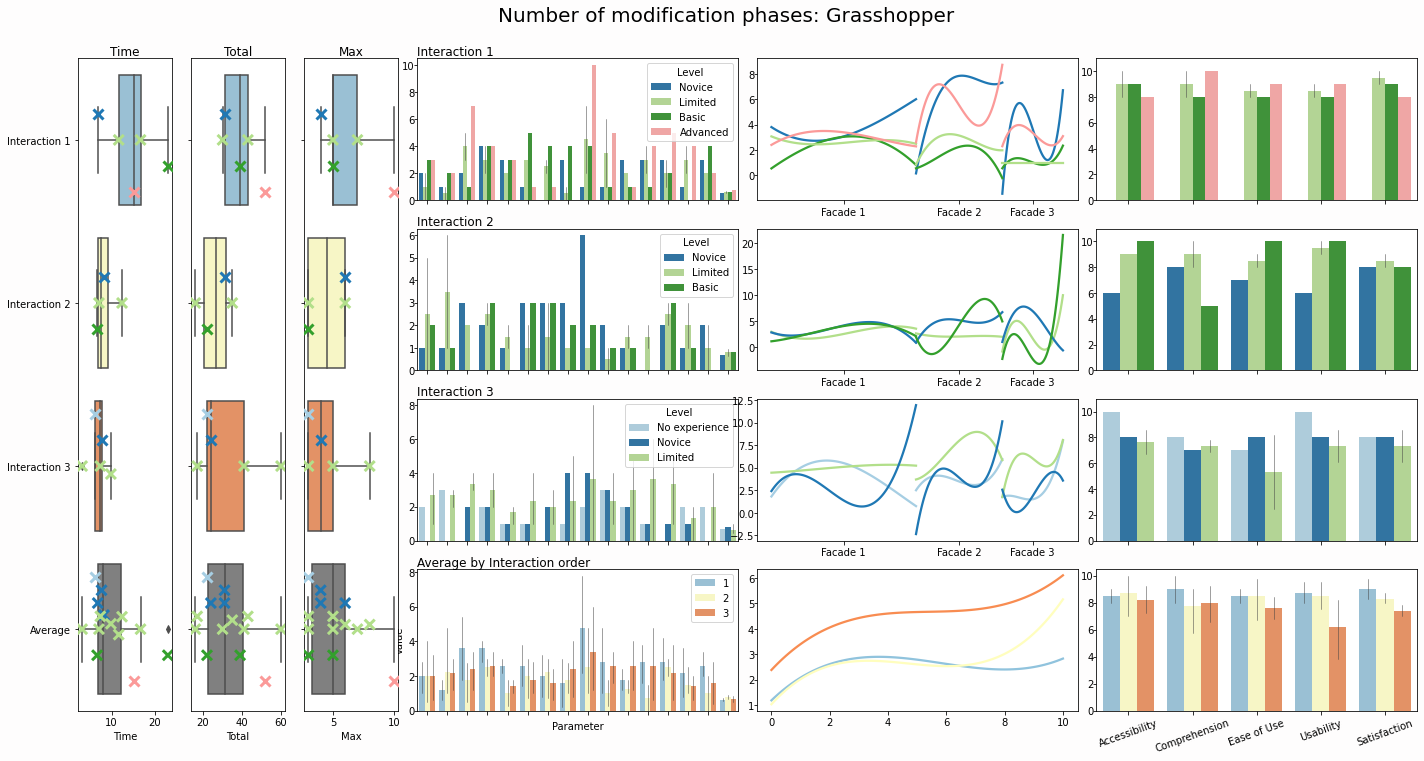

In [18]:
keeplist2 =['Time','Total','Max']
an.order_analysis(1, phase_df, time_phases_df, feedback_df, keeplist2, 4, 'Number of modification phases')
plt.savefig('output/gh_order_phases.png',bbox_inches='tight')

### Hybrid

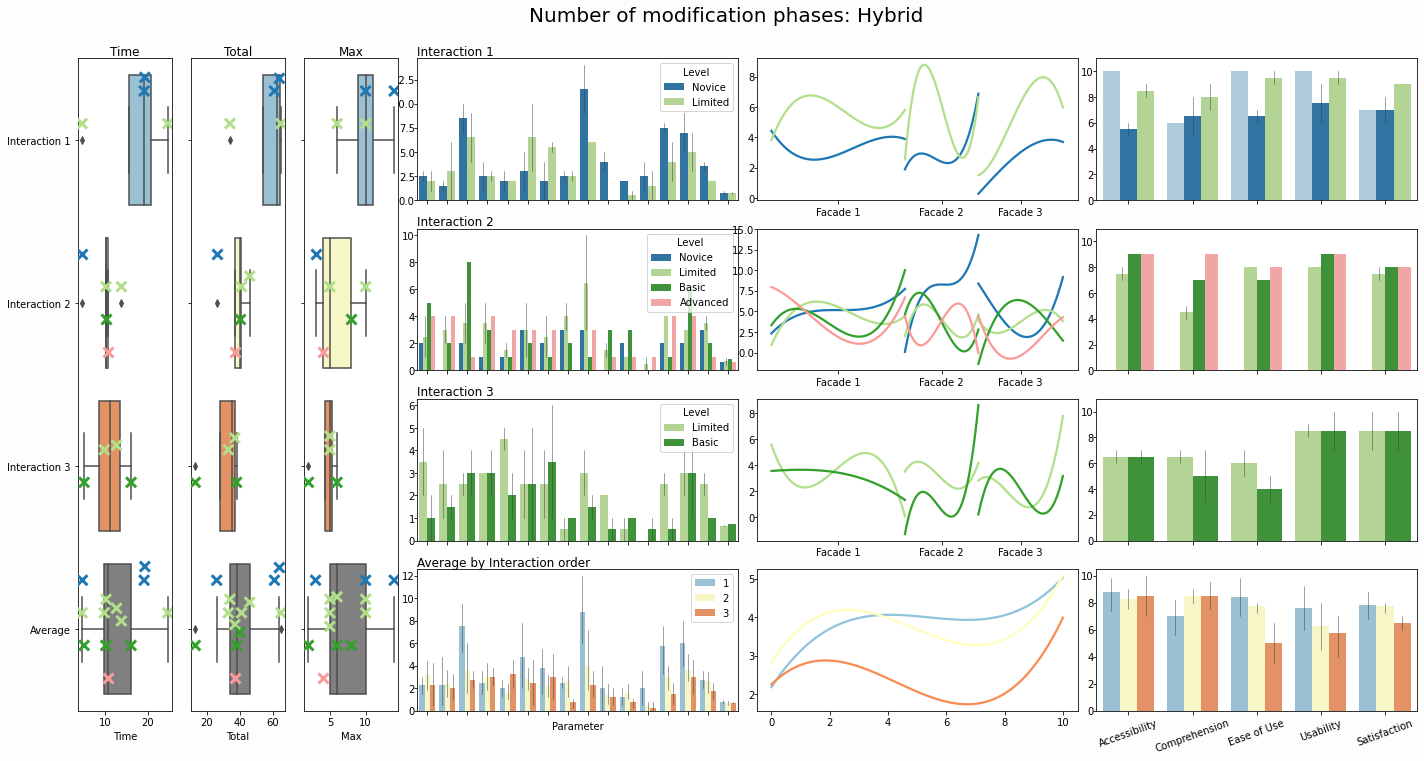

In [19]:
an.order_analysis(2, phase_df.drop('Adrian', axis=0, level='Name'), time_phases_df.drop('Adrian', axis=0, level='Name'), feedback_df, keeplist2, 8, 'Number of modification phases')
plt.savefig('output/hybrid_order_phases.png',bbox_inches='tight')

### Plugin

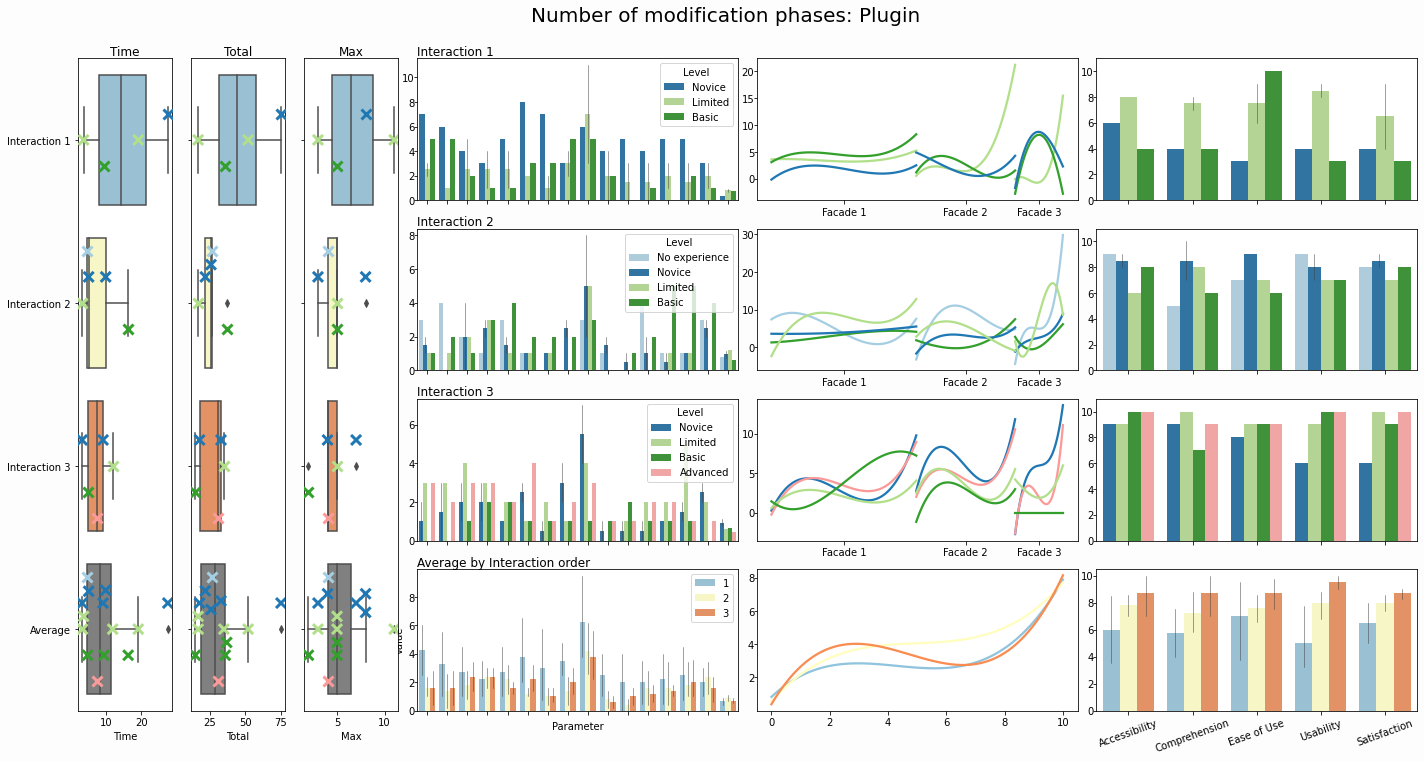

In [20]:
an.order_analysis(3, phase_df, time_phases_df, feedback_df, keeplist2, 3, 'Number of modification phases')
plt.savefig('output/plugin_order_phases.png',bbox_inches='tight')

# Unique

In [21]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 12,'display.max_colwidth',50):
    display(unique_df.round(decimals=2))
unique_df.round(decimals=2).to_excel('output/testexcel-unique.xlsx')

Time  TileXSize  \
Name     Level     Order Type               Object                      
Khulan   303112001 1     Grasshopper        2       121.00       5.00   
                                            3        92.00       3.00   
                                            4        21.00       1.00   
                   2     Hybrid             2        25.00       1.00   
                                            3        11.00       3.00   
                                            4        12.00       3.00   
                   3     Plugin             2        12.00       1.00   
                                            3        25.00       1.00   
                                            4         4.00       1.00   
                   0     Tot                0       323.00      19.00   
                         Average            0        35.89       2.11   
                         Standard Deviation 0        41.27       1.45   
Adrian   404000100 3     Grasshopper        2        75.00       4.00   
                                            3        17.00       1.00   
                                            4        16.00       5.00   
                   1     Hybrid             2        39.00       6.00   
                                            3        13.00       5.00   
                                            4        12.00       6.00   
                   2     Plugin             2        20.00       2.00   
                                            3        25.00       3.00   
                                            4         3.00       2.00   
                   0     Tot                0       220.00      34.00   
                         Average            0        24.44       3.78   
                         Standard Deviation 0        21.39       1.86   
Mathilde 404223002 2     Grasshopper        2        72.00       1.00   
                                            3        25.00       1.00   
                                            4         4.00       1.00   
                   3     Hybrid             2        21.00       1.00   
                                            3        50.00      13.00   
                                            4        17.00       4.00   
                   1     Plugin             2        20.00       3.00   
                                            3         3.00       2.00   
                                            4         3.00       2.00   
                   0     Tot                0       215.00      28.00   
                         Average            0        23.89       3.11   
                         Standard Deviation 0        23.28       3.86   
Virgil   303334003 1     Grasshopper        2        81.00       5.00   
                                            3        29.00       2.00   
                                            4        20.00       1.00   
                   3     Hybrid             2        68.00       9.00   
                                            3         2.00       1.00   
                                            4        11.00       1.00   
                   2     Plugin             2        24.00       2.00   
                                            3        31.00       1.00   
                                            4        10.00       1.00   
                   0     Tot                0       276.00      23.00   
                         Average            0        30.67       2.56   
                         Standard Deviation 0        26.75       2.74   
FannyM   404113101 2     Grasshopper        2       102.00       5.00   
                                            3        40.00       1.00   
                                            4        24.00       1.00   
                   1     Hybrid             2       111.00      11.00   
                                            3        41.00       1.00   
                                       

## Étude Générale

### Grasshopper

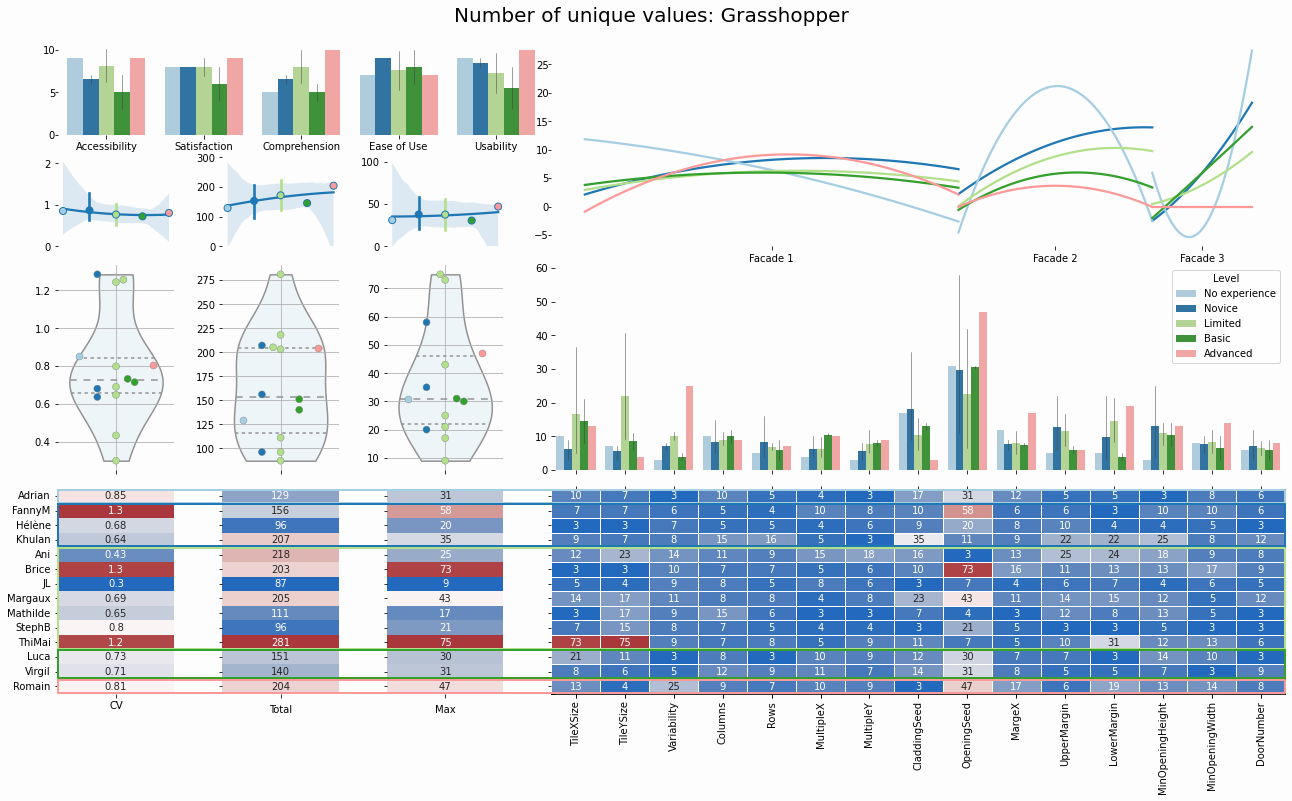

In [29]:
an.context_analysis(0, unique_df, time_unique_df, feedback_df, study_columns=['CV', 'Total', 'Max'], b=4, title='Number of unique values')
plt.savefig('output/gh_unique.png',bbox_inches='tight')

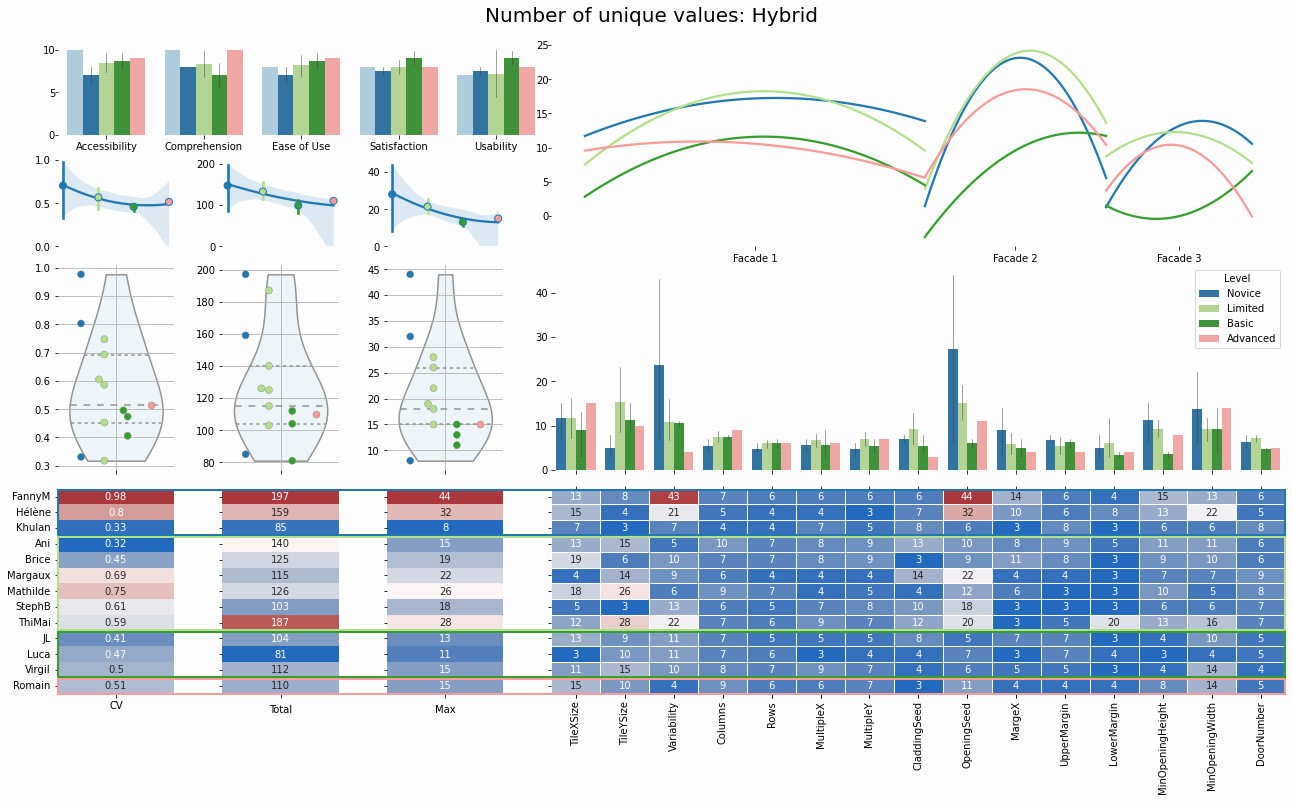

In [23]:
an.context_analysis(1, unique_df.drop('Adrian', axis=0, level='Name'), time_unique_df.drop('Adrian', axis=0, level='Name'), feedback_df, study_columns=['CV', 'Total', 'Max'], b=8, title='Number of unique values', y2=0.1785)
plt.savefig('output/hybrid_unique.png',bbox_inches='tight')

### Plugin

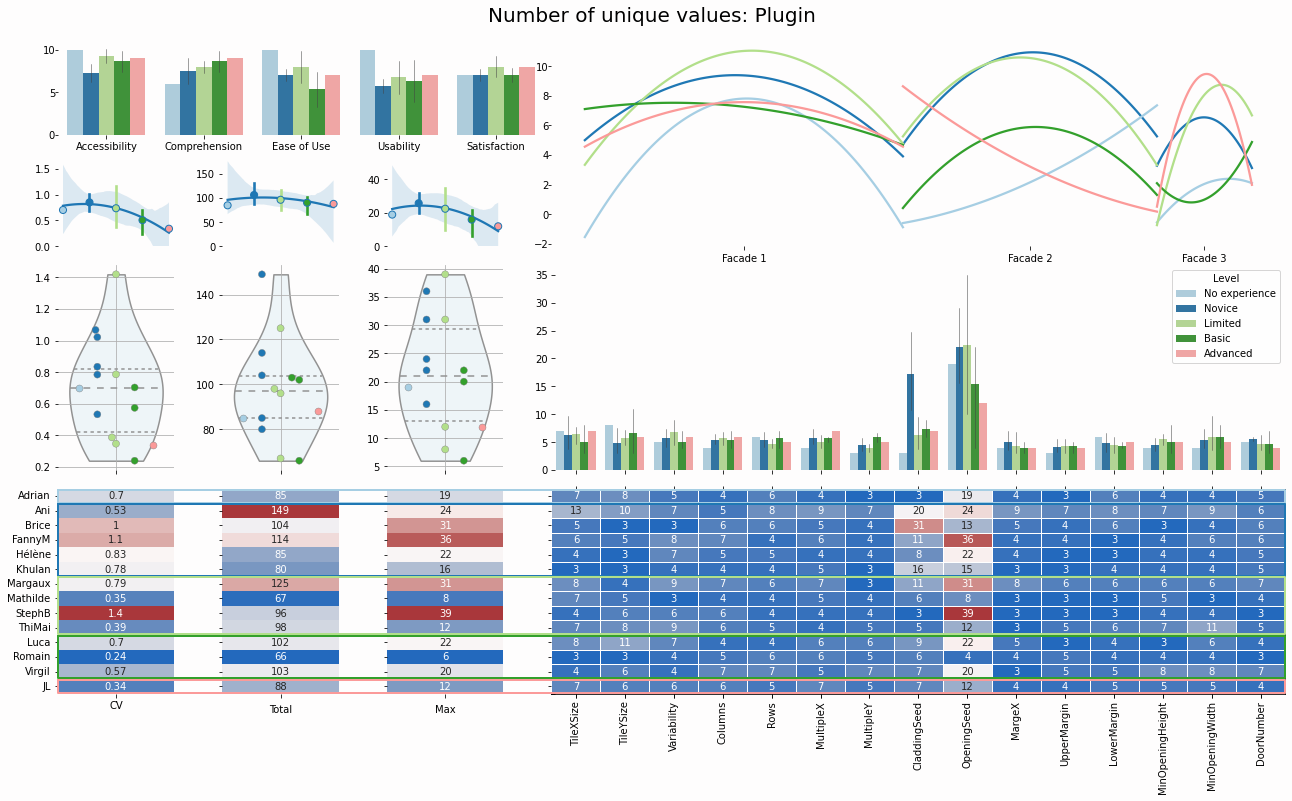

In [24]:
an.context_analysis(2, unique_df, time_unique_df, feedback_df, study_columns=['CV', 'Total', 'Max'], b=3, title='Number of unique values', y2=0.175)
plt.savefig('output/plugin_unique.png',bbox_inches='tight')

### Total 

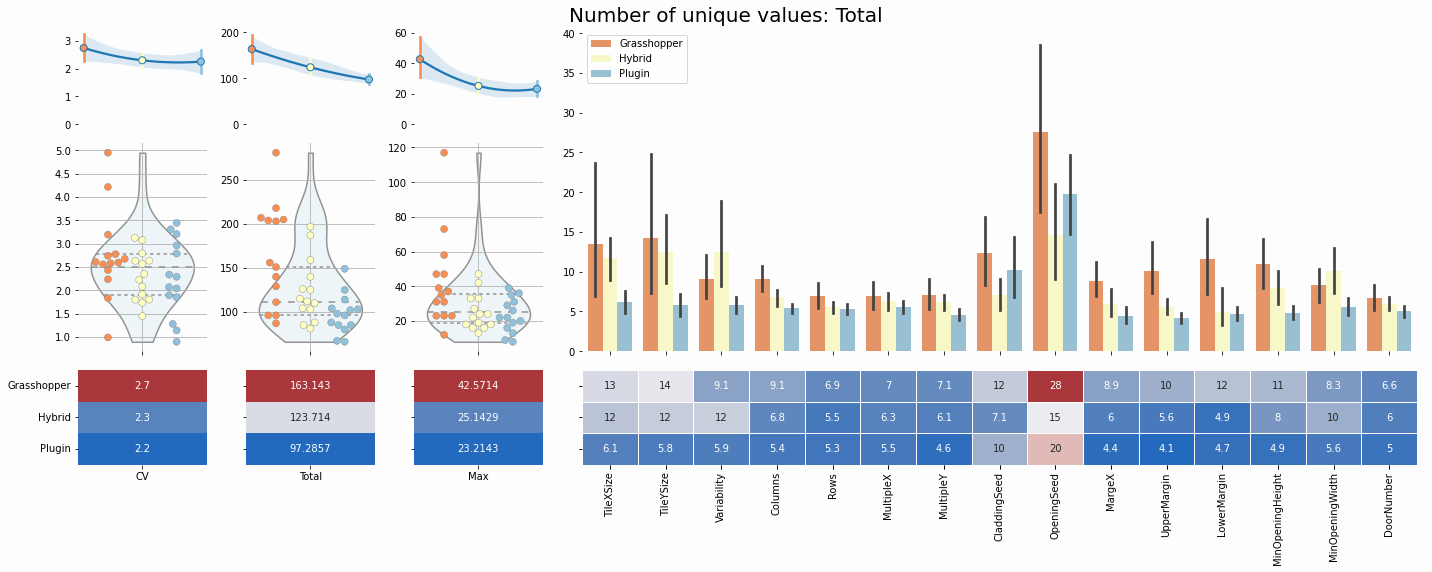

In [25]:
an.global_analysis(unique_df, ['CV', 'Total', 'Max'], 'Number of unique values')
plt.savefig('output/global_unique.png',bbox_inches='tight')

## Etude selon l'ordre

### Grasshopper

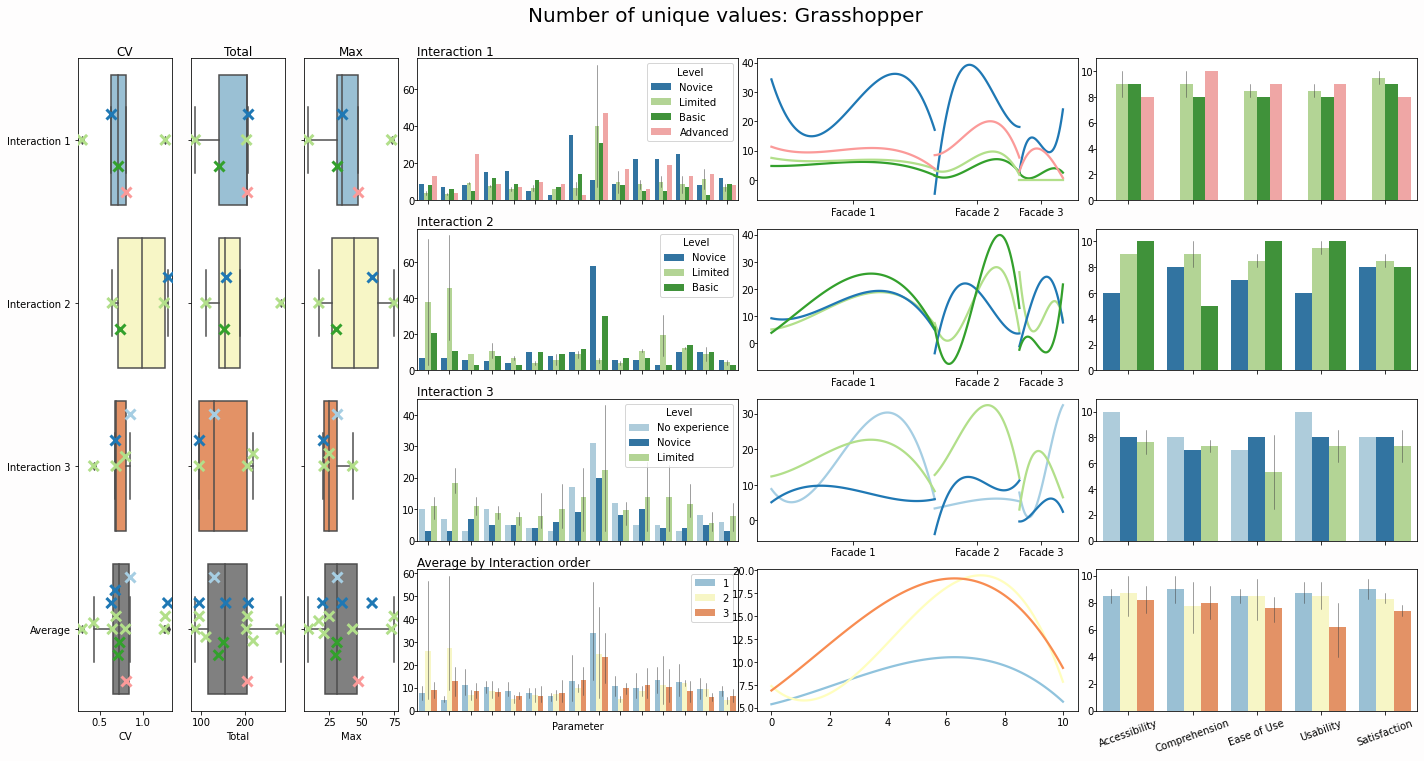

In [26]:
keeplist3 =['CV','Total','Max']
an.order_analysis(1, unique_df, time_unique_df, feedback_df, keeplist3, 4, 'Number of unique values')
plt.savefig('output/gh_order_unique.png',bbox_inches='tight')

### Hybrid

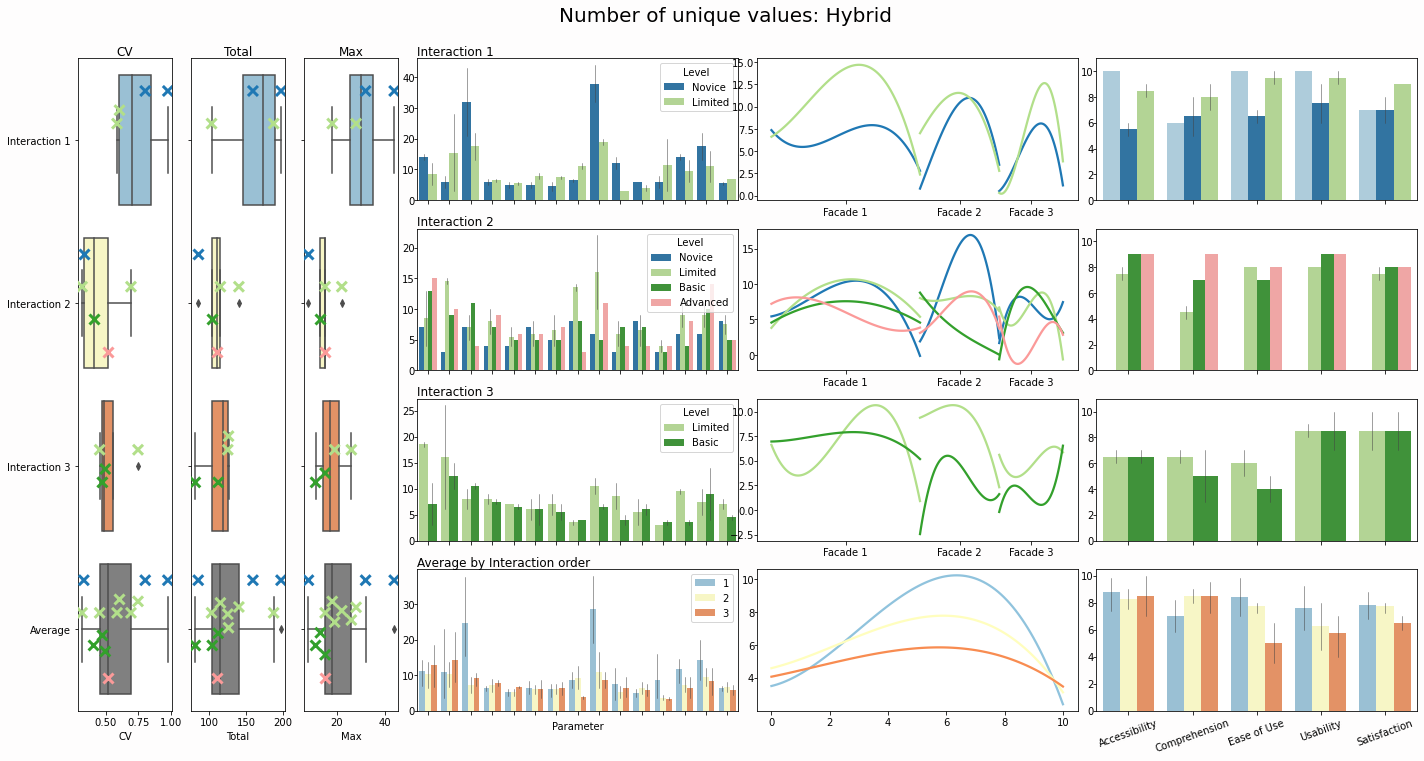

In [27]:
an.order_analysis(2, unique_df.drop('Adrian', axis=0, level='Name'), time_unique_df.drop('Adrian', axis=0, level='Name'), feedback_df, keeplist3, 8, 'Number of unique values')
plt.savefig('output/hybrid_order_unique.png',bbox_inches='tight')

### Plugin

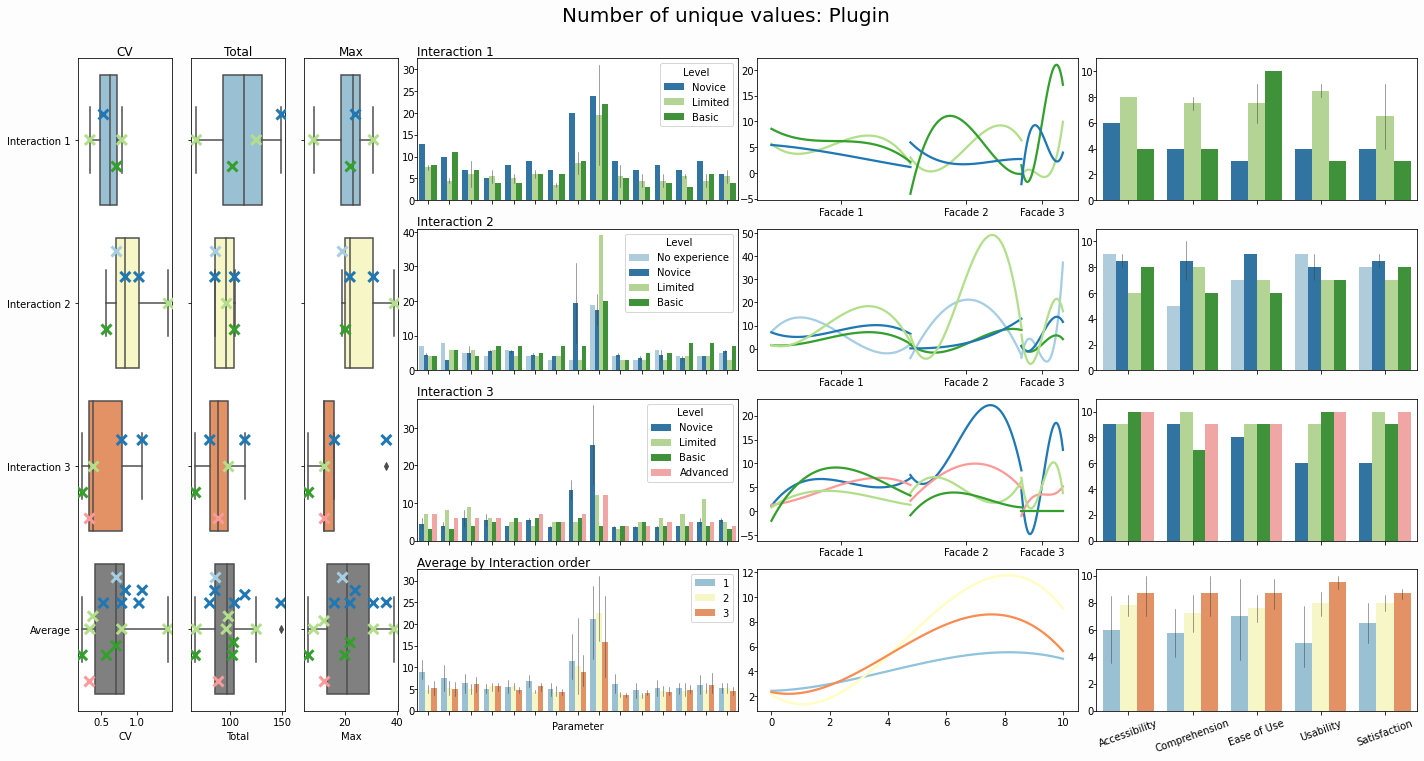

In [28]:
an.order_analysis(3, unique_df, time_unique_df, feedback_df, keeplist3, 3, 'Number of unique values')
plt.savefig('output/plugin_order_unique.png',bbox_inches='tight')